In [2]:
import serial
import serial.tools.list_ports
import time
import json
import io
import struct
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pathlib
from PIL import Image

In [3]:
batch_size = 32
img_height = 28
img_width = 28
img_channel = 1
number_of_classes = 10

In [4]:
load_data_result = tf.keras.datasets.fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# reshape dataset to have a single channel
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)

print(train_labels[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [132]:
ports = serial.tools.list_ports.comports()

for __port in ports:
    print(__port.name)

cu.wlan-debug
cu.Bluetooth-Incoming-Port


In [231]:
#port = serial.Serial("/dev/cu.usbmodem101", baudrate=115200, timeout=1)
port = serial.Serial("/dev/cu.usbmodem401101", baudrate=115200, timeout=1)

In [185]:
port.close()
port.open()

In [232]:
port.read_all()

b''

In [11]:
def send_request_classify_image():
    img_size = img_width * img_height * img_channel * 4
    command = {"command":0, "ds":img_size, "repeat": 1}
    command_json = json.dumps(command)
    print(command_json)

    command_json += "\n"
    port.write(command_json.encode())
    time.sleep(0.1)

    print(port.read_all())

In [12]:
def convert_float_list_to_bytes(data):
    data_bytes = []
    for dat in data:
        bytes_ = list(struct.pack("!f", dat))
        bytes_.reverse()
        data_bytes.extend(bytes_)

    return data_bytes

(784,)
3136


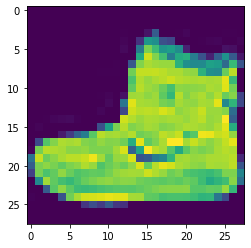

In [13]:
image_plain = train_images[0]
image = np.float32(image_plain).reshape(img_width * img_height * img_channel)
print(np.shape(image))
image_bytes = convert_float_list_to_bytes(image)
print(len(image_bytes))

plt.imshow(image_plain)

In [14]:
def create_image_bytes(k):
    image = np.float32(train_images[k])
    image_label = train_labels[k]
    image = image.reshape(28*28,)
    print(np.shape(image))
    image_bytes = convert_float_list_to_bytes(image)
    print(len(image_bytes))
    return (image_bytes, image_label)

In [19]:
def send_image_to_classify(image_bytes):
    port.write(image_bytes)

    time.sleep(2)

    timing_samples = []

    while(True):
        lineData = port.readline()
        line = str(lineData)

        if len(lineData) == 0:
            break

        lineJsonData = io.BytesIO(lineData)
        try:
            lineJson = json.load(lineJsonData)
            print(lineJson)
            if lineJson["type"] == 1:
                data = lineJson["payload"]["data"]
                for sample in data:
                    timing_samples.append(sample["time_us"])
                    print("Time:", sample["time_us"] / 1000, "ms")
        except:
            print("No json line:", line)
            
            #print(lineJson)

    timing_samples = np.array(timing_samples)

    pd.DataFrame(timing_samples).describe()

In [233]:
send_request_classify_image()
(image_bytes, image_label) = create_image_bytes(3)
send_image_to_classify(image_bytes)
print("Y:", image_label)

{"command": 0, "ds": 3136, "repeat": 1}
b'{"payload":"[1] Received {\\"command\\": 0, \\"ds\\": 3136, \\"repeat\\": 1}\\n\\n","type":0}\r\n{"payload":"[2] Received command with type: 0\\n","type":0}\r\n{"payload":"[2] New state: 3\\n","type":0}\r\n'
(784,)
3136
{'payload': '[2] Received data\n', 'type': 0}
{'payload': '[2] New state: 4\n', 'type': 0}
{'payload': '[2] New state: 5\n', 'type': 0}
{'payload': {'data': [{'probabilities': [0.10250141471624374, 0.08887112885713577, 0.1041807308793068, 0.10907047986984253, 0.08820430934429169, 0.08318603783845901, 0.1092618927359581, 0.10860847681760788, 0.10703395307064056, 0.09908152371644974], 'time_us': 128985}]}, 'type': 1}
Time: 128.985 ms
{'payload': '[2] New state: 2\n', 'type': 0}
Y: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


# CR 32

{'payload': {'data': [{'probabilities': [0.36499977111816406, 0.053862061351537704, 0.00036528994678519666, 0.45516732335090637, 0.005947269964963198, 1.5158089809119701e-05, 0.11882230639457703, 3.7024791565976045e-10, 0.0008207294740714133, 8.713860921716332e-08], 'time_us': 1356765}]}, 'type': 1}
Time: 1356.765 ms

## Conv only

#### Comparing float:
```
if(filter_value != 0)
{
}
```
{'payload': {'data': [{'probabilities': [0.36499977111816406, 0.053862061351537704, 0.00036528994678519666, 0.45516732335090637, 0.005947269964963198, 1.5158089809119701e-05, 0.11882230639457703, 3.7024791565976045e-10, 0.0008207294740714133, 8.713860921716332e-08], 'time_us': 967486}]}, 'type': 1}
Time: 967.486 ms

{'payload': {'data': [{'probabilities': [0.013979465700685978, 0.00048780167708173394, 0.0012296761851757765, 0.00023730166140012443, 0.00019620124658104032, 0.004381695296615362, 0.8750729560852051, 1.3949943422630895e-09, 0.10441488027572632, 5.301180383554538e-09], 'time_us': 811976}]}, 'type': 1}
Time: 811.976 ms

#### Comparing exponent only:
```
if(*(char*)&filter_value != 0)
{
}
```
{'payload': {'data': [{'probabilities': [0.36499977111816406, 0.053862061351537704, 0.00036528994678519666, 0.45516732335090637, 0.005947269964963198, 1.5158089809119701e-05, 0.11882230639457703, 3.7024791565976045e-10, 0.0008207294740714133, 8.713860921716332e-08], 'time_us': 752577}]}, 'type': 1}
Time: 752.577 ms

## Conv and Dense

#### Comparing exponent only:
{'payload': {'data': [{'probabilities': [0.36503323912620544, 0.053775303065776825, 0.00036532344529405236, 0.45520904660224915, 0.005947815719991922, 1.5118102055566851e-05, 0.11883319914340973, 3.7028186072873837e-10, 0.0008208047365769744, 8.714659571751326e-08], 'time_us': 619878}]}, 'type': 1}
Time: 619.878 ms